# Importing ECMWF IFS Weather Forecast to DHIS2

In [1]:
from datetime import date
import json

import geopandas as gpd
import xarray as xr
from earthkit import transforms

from dhis2_client import DHIS2Client

from dhis2eo.data.ecmwf import ifs
from dhis2eo.integrations.pandas import dataframe_to_dhis2_json

In [2]:
# DHIS2 connection
DHIS2_BASE_URL = "https://play.im.dhis2.org/stable-2-42-3-1"
DHIS2_USERNAME = "admin"
DHIS2_PASSWORD = "district"

# DHIS2 import settings
DHIS2_DATA_ELEMENT_ID = '<INSERT-DATA-ELEMENT-ID>'
DHIS2_ORG_UNIT_LEVEL = 2
DHIS2_DRY_RUN = True                            # default to safe dry-run mode; set to False for actual import
DHIS2_TIMEZONE_OFFSET = 0                       # set to UTC timezone offset for your country

# IFS import configuration
IMPORT_VARIABLE = "tp"         # ERA5 variable to download (as named in the CDS catalogue)
IMPORT_VALUE_COL = "tp"                         # variable name in the downloaded xarray dataset
IMPORT_IS_CUMULATIVE = True                     # indicates whether the input data is cumulative over time (e.g. ERA5 precipitation)
IMPORT_FROM_UNITS = "m"                         # units of the original data values
IMPORT_TO_UNITS = "mm"                          # convert to these units before import
IMPORT_START_DATE = "2026-01-01"                # how far back in time to start import
IMPORT_END_DATE = "2026-02-02" #date.today().isoformat()      # automatically tries to import the latest data

# Download settings
DOWNLOAD_FOLDER = "../test_outputs/ecmwf"
DOWNLOAD_PREFIX = "ifs-hourly-precip"          # prefix for caching downloads; existing files are reused

# Aggregation settings
TEMPORAL_AGGREGATION = "sum"
SPATIAL_AGGREGATION = "mean"

## Connect to DHIS2

In [3]:
# Client configuration
client = DHIS2Client(
    base_url=DHIS2_BASE_URL,
    username=DHIS2_USERNAME,
    password=DHIS2_PASSWORD,
)
info = client.get_system_info()
print("Current DHIS2 version:", info["version"])

Current DHIS2 version: 2.42.3.1


## Create DHIS2 data elements if needed

**Important**: First run the Climate Tools metadata creation notebook to create dataset with precip and temp data elements. 

In [19]:
# create forecast data element
data_element = {
    "name": "Precipitation forecast, latest (IFS)",
    "shortName": "Precip forecast (IFS)",
    "code": "IFS_FCST_PRECIP",
    "description": "Daily precipitation forecast (latest available run). Source: ECMWF IFS. Values represent spatially aggregated precipitation over the org unit area. Forecast horizons are collapsed so that each date contains the most recent forecast issued for that day. Units: millimetres (mm).",
    "valueType": "NUMBER",
    "aggregationType": "SUM",
    "domainType": "AGGREGATE"
}
precipitation_created = client.create_data_element(data_element)
print(f"Data element creation status: {precipitation_created['status']} and UID: {precipitation_created['response']['uid']}")

Data element creation status: OK and UID: lnAihNgiZEg


In [43]:
# get existing dataset
dataset_name = 'Daily climate data'
dataset = list(client.get_data_sets(filter=[f"name:eq:{dataset_name}"], fields='*'))[0]
dataset

{'name': 'Daily climate data',
 'created': '2026-02-03T18:55:34.900',
 'lastUpdated': '2026-02-03T19:26:47.540',
 'translations': [],
 'createdBy': {'id': 'xE7jOejl9FI',
  'code': None,
  'name': 'John Traore',
  'displayName': 'John Traore',
  'username': 'admin'},
 'favorites': [],
 'lastUpdatedBy': {'id': 'xE7jOejl9FI',
  'code': None,
  'name': 'John Traore',
  'displayName': 'John Traore',
  'username': 'admin'},
 'sharing': {'owner': 'xE7jOejl9FI',
  'external': False,
  'users': {},
  'userGroups': {},
  'public': 'rw------'},
 'shortName': 'Daily climate data',
 'dimensionItemType': 'REPORTING_RATE',
 'legendSets': [],
 'periodType': 'Daily',
 'dataInputPeriods': [],
 'dataSetElements': [{'dataSet': {'id': 'eBdp262eZqe'},
   'dataElement': {'id': 'lnAihNgiZEg'}},
  {'dataSet': {'id': 'eBdp262eZqe'}, 'dataElement': {'id': 'eWrsGiBrU0t'}},
  {'dataSet': {'id': 'eBdp262eZqe'}, 'dataElement': {'id': 'itf4K2B1o5h'}}],
 'indicators': [],
 'compulsoryDataElementOperands': [],
 'sectio

In [42]:
# update dataset to include new data element
dataset_update = {
  "dataSetElements": [
    {
      "dataSet": {"id": dataset['id']},
      "dataElement": { "id": precipitation_created['response']['uid'] }
    }
  ]
}
dataset['dataSetElements'].extend(dataset_update['dataSetElements'])
#dataset
client.update_data_set(dataset['id'], dataset)
#client.patch(f"/api/dataSets/{dataset['id']}", params=dataset_update)

{'httpStatus': 'OK',
 'httpStatusCode': 200,
 'status': 'OK',
 'response': {'uid': 'eBdp262eZqe',
  'klass': 'org.hisp.dhis.dataset.DataSet',
  'errorReports': [],
  'responseType': 'ObjectReportWebMessageResponse'}}

## Get DHIS2 organisation units

In [4]:
# Get org units GeoJSON from DHIS2
org_units_geojson = client.get_org_units_geojson(level=DHIS2_ORG_UNIT_LEVEL)

# Convert GeoJSON to geopandas
org_units = gpd.read_file(json.dumps(org_units_geojson))
org_units

,id,code,name,level,parent,parentGraph,groups,geometry
0,O6uvpzGd5pu,OU_264,Bo,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy]","POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,fdc6uOvgoji,OU_193190,Bombali,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, J40PpdN4Wkk, GGghZsfu7qV]","POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,lc3eMKXaEfw,OU_197385,Bonthe,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, jqBqIXoXpfy, GGghZsfu7qV]","MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,jUb8gELQApl,OU_204856,Kailahun,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, nlX2VoouN63]","POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,PMa2VCrupOd,OU_211212,Kambia,2,ImspTQPwCqd,ImspTQPwCqd,"[w1Atoz18PCL, GGghZsfu7qV, b0EsAxm8Nge, nlX2Vo...","MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,kJq2mPyFEHo,OU_222616,Kenema,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL]","POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,qhqAxPSTUXp,OU_226213,Koinadugu,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Vth0fbpFcsO,OU_233310,Kono,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, J40PpdN4Wkk]","POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,jmIPBj66vD6,OU_246990,Moyamba,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, jqBqIXoXpfy]","MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,TEQlaapDQoK,OU_254945,Port Loko,2,ImspTQPwCqd,ImspTQPwCqd,"[f25dqv3Y7Z0, w1Atoz18PCL, b0EsAxm8Nge]","MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


## Download the data

In [6]:
print(f'Downloading data for the period: {IMPORT_START_DATE} to {IMPORT_END_DATE}...')
files = ifs.hourly.download(
    start=IMPORT_START_DATE, 
    end=IMPORT_END_DATE, 
    bbox=org_units.total_bounds, 
    dirname=DOWNLOAD_FOLDER, 
    prefix=DOWNLOAD_PREFIX, 
    variables=[IMPORT_VARIABLE],
    server='azure',
    overwrite=False,
)
files

INFO - 2026-02-03 19:13:47,984 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-01
INFO - 2026-02-03 19:13:47,987 - dhis2eo.data.ecmwf.ifs.hourly - File already downloaded: C:\Users\karimba\Documents\Github\dhis2eo\tests\test_outputs\ecmwf\ifs-hourly-precip_2026-01-01.nc
INFO - 2026-02-03 19:13:47,989 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-02
INFO - 2026-02-03 19:14:20,255 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-03
INFO - 2026-02-03 19:14:51,491 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-04
INFO - 2026-02-03 19:15:50,383 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-05
INFO - 2026-02-03 19:16:58,160 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-06
INFO - 2026-02-03 19:17:41,400 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-07
INFO - 2026-02-03 19:18:13,711 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-08
INFO - 2026-02-03 19:18:43,281 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-09
INFO - 2026-02-03 19:19:19,466 - dhis2eo.data.ecmwf.ifs.hourly - Day 2026-01-10
INFO - 2026

[WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-01.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-02.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-03.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-04.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-05.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-06.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-07.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outputs/ecmwf/ifs-hourly-precip_2026-01-08.nc'),
 WindowsPath('C:/Users/karimba/Documents/Github/dhis2eo/tests/test_outpu

## Open the data

In [7]:
ds_hourly = xr.open_mfdataset(files)
ds_hourly

C:\Users\karimba\AppData\Local\Temp\ipykernel_37612\3061293047.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  ds_hourly = xr.open_mfdataset(files)


<xarray.Dataset> Size: 2MB
Dimensions:     (time: 33, step: 85, latitude: 13, longitude: 12)
Coordinates:
  * time        (time) datetime64[ns] 264B 2026-01-01 2026-01-02 ... 2026-02-02
  * step        (step) timedelta64[ns] 680B 0 days 00:00:00 ... 15 days 00:00:00
  * latitude    (latitude) float64 104B 10.0 9.75 9.5 9.25 ... 7.75 7.5 7.25 7.0
  * longitude   (longitude) float64 96B -13.25 -13.0 -12.75 ... -10.75 -10.5
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 264B 2026-01-01 2026-01-02 ... 2026-02-02
Data variables:
    tp          (time, step, latitude, longitude) float32 2MB dask.array<chunksize=(1, 85, 13, 12), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-03T19:13 GRIB to CDM+CF via cfgrib-0.9.1...

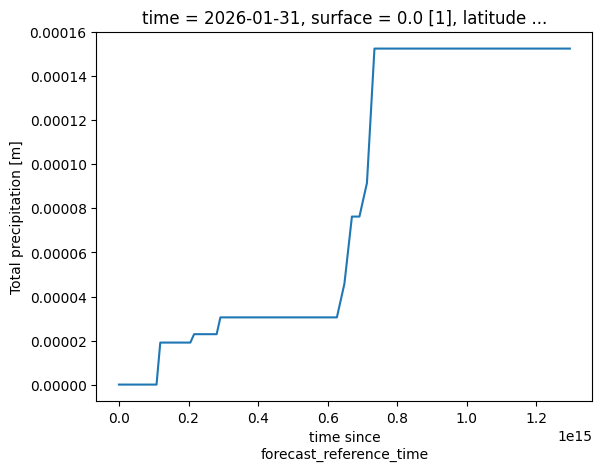

In [136]:
ds_hourly.isel(time=0, longitude=0, latitude=0)['tp'].plot()

## Handle cumulative variables

In [8]:
if IMPORT_IS_CUMULATIVE:
    print('Converting cumulative to incremental variable...')
    # 1. Calculate the difference (this results in N-1 steps)
    ds_diffs = ds_hourly.diff(dim='step')
    # 2. Re-index to the original 'step' coordinates to bring back the missing first step
    # This will put a 'NaN' at Step 1 (the first hour)
    ds_diffs = ds_diffs.reindex(step=ds_hourly.step)
    # 3. Fill that NaN with the original Step 1 value (the baseline accumulation)
    ds_hourly = ds_diffs.fillna(ds_hourly.isel(step=0))
    # TODO: What about neg values which are likely from minior errors
    # ......

Converting cumulative to incremental variable...


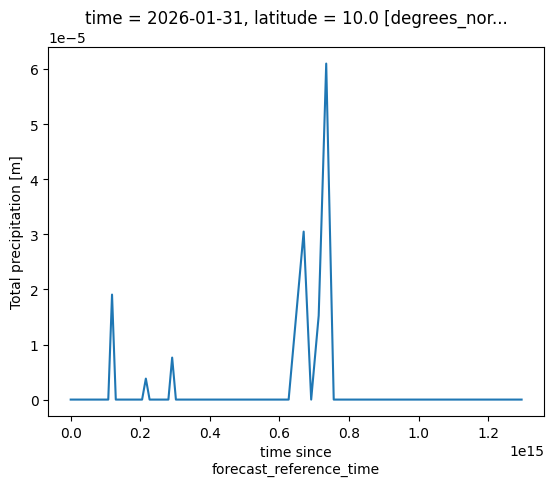

In [138]:
ds_hourly.isel(time=0, longitude=0, latitude=0)['tp'].plot()

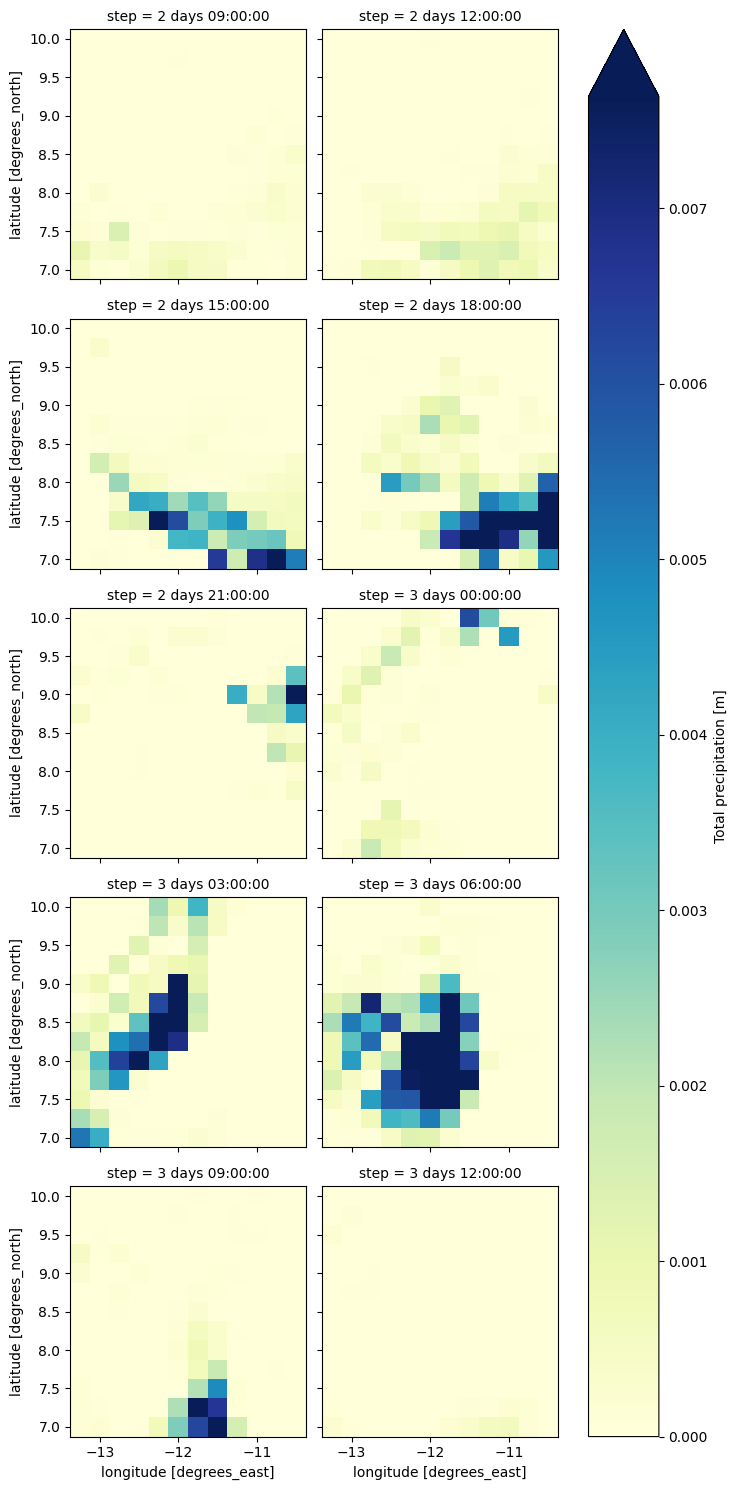

In [139]:
# Plot the evolution for some time steps
# Select the first x steps from day 1
subset = ds_hourly.sel(time='2026-02-01').isel(step=slice(19, 27+2))
# Use 'col' to create subplots automatically
subset['tp'].plot(
    col="step",      # Create a new subplot for every value in 'step'
    col_wrap=2,      # Maximum of 2 subplots per row
    cmap="YlGnBu",   # Nice precipitation color scale
    robust=True      # Ignores extreme outliers for better color scaling
)

## Aggregate from hours to days

In [9]:
print("Aggregating temporally...")
# TODO: not currently handling timezone... 
ds_daily = getattr(ds_hourly.resample(step="24h"), TEMPORAL_AGGREGATION)()
#ds_daily = transforms.temporal.daily_reduce(
#    ds_hourly[IMPORT_VALUE_COL],
#    how=TEMPORAL_AGGREGATION,
#    time_shift={"hours": DHIS2_TIMEZONE_OFFSET},
#    remove_partial_periods=False,
#)
ds_daily

Aggregating temporally...


<xarray.Dataset> Size: 330kB
Dimensions:     (step: 16, time: 33, latitude: 13, longitude: 12)
Coordinates:
  * step        (step) timedelta64[ns] 128B 0 days 1 days ... 14 days 15 days
  * time        (time) datetime64[ns] 264B 2026-01-01 2026-01-02 ... 2026-02-02
  * latitude    (latitude) float64 104B 10.0 9.75 9.5 9.25 ... 7.75 7.5 7.25 7.0
  * longitude   (longitude) float64 96B -13.25 -13.0 -12.75 ... -10.75 -10.5
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 264B 2026-01-01 2026-01-02 ... 2026-02-02
Data variables:
    tp          (step, time, latitude, longitude) float32 329kB dask.array<chunksize=(1, 1, 13, 12), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-03T19:13 GRIB to CDM+CF via cfgrib-0.9.1...

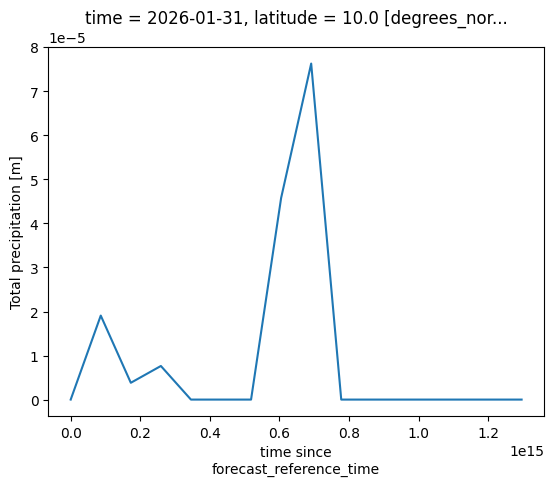

In [141]:
ds_daily.isel(time=0, longitude=0, latitude=0)['tp'].plot()

In [10]:
# 1. Calculate the absolute forecast time (Initialization + Offset)
# This creates a 2D coordinate array [time, step]
forecast_time = ds_hourly["time"] + ds_hourly["step"]
# 2. Assign it to the dataset
ds_daily = ds_daily.assign_coords(forecast_time=forecast_time)
ds_daily

<xarray.Dataset> Size: 335kB
Dimensions:        (step: 16, time: 33, latitude: 13, longitude: 12)
Coordinates:
  * step           (step) timedelta64[ns] 128B 0 days 1 days ... 14 days 15 days
  * time           (time) datetime64[ns] 264B 2026-01-01 ... 2026-02-02
  * latitude       (latitude) float64 104B 10.0 9.75 9.5 9.25 ... 7.5 7.25 7.0
  * longitude      (longitude) float64 96B -13.25 -13.0 -12.75 ... -10.75 -10.5
    surface        float64 8B 0.0
    valid_time     (time) datetime64[ns] 264B 2026-01-01 ... 2026-02-02
    forecast_time  (time, step) datetime64[ns] 4kB 2026-01-01 ... 2026-02-17
Data variables:
    tp             (step, time, latitude, longitude) float32 329kB dask.array<chunksize=(1, 1, 13, 12), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-03T19:13 GRIB to CDM+CF via cfgrib-0.9.1...

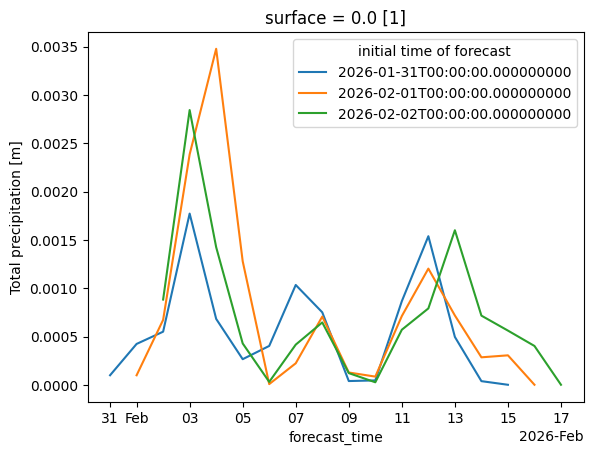

In [143]:
# plot forecasts as spatial average for whole country
ds_daily['tp'].mean(dim=['latitude', 'longitude']).plot(x='forecast_time', hue='time')

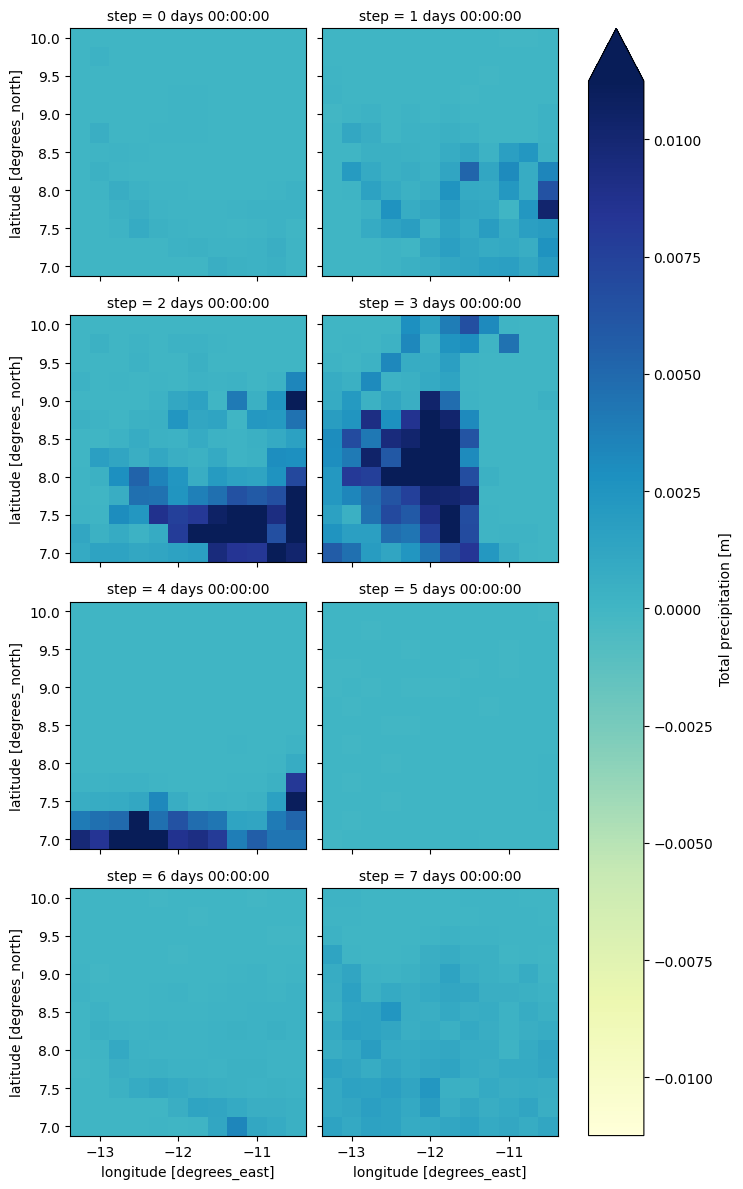

In [149]:
# Plot the evolution for some time steps
# Select the first x steps from day 1
subset = ds_daily.sel(time='2026-02-01').isel(step=slice(0, 8))
# Use 'col' to create subplots automatically
subset['tp'].plot(
    col="step",      # Create a new subplot for every value in 'step'
    col_wrap=2,      # Maximum of 2 subplots per row
    cmap="YlGnBu",   # Nice precipitation color scale
    robust=True      # Ignores extreme outliers for better color scaling
)

## Aggregate to organisation units

In [11]:
print("Aggregating to organisation units...")
ds_org_units = transforms.spatial.reduce(
    ds_daily,
    org_units,
    mask_dim="id",
    how=SPATIAL_AGGREGATION,
)
ds_org_units

Aggregating to organisation units...


<xarray.Dataset> Size: 32kB
Dimensions:        (time: 33, step: 16, id: 13)
Coordinates:
  * time           (time) datetime64[ns] 264B 2026-01-01 ... 2026-02-02
  * step           (step) timedelta64[ns] 128B 0 days 1 days ... 14 days 15 days
  * id             (id) object 104B 'O6uvpzGd5pu' ... 'at6UHUQatSo'
    surface        float64 8B 0.0
    valid_time     (time) datetime64[ns] 264B 2026-01-01 ... 2026-02-02
    forecast_time  (time, step) datetime64[ns] 4kB 2026-01-01 ... 2026-02-17
Data variables:
    tp             (id, step, time) float32 27kB 0.009059 0.001055 ... 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-03T19:13 GRIB to CDM+CF via cfgrib-0.9.1...

## Post processing

In [14]:
dataframe = ds_org_units.to_dataframe().reset_index()
dataframe.query("id=='O6uvpzGd5pu'")

,time,step,id,surface,valid_time,forecast_time,tp
0,2026-01-01,0 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-01,0.009059
13,2026-01-01,1 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-02,0.000223
26,2026-01-01,2 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-03,0.001511
39,2026-01-01,3 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-04,0.001801
52,2026-01-01,4 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-05,0.002638
...,...,...,...,...,...,...,...
6799,2026-02-02,11 days,O6uvpzGd5pu,0.0,2026-02-02,2026-02-13,0.002762
6812,2026-02-02,12 days,O6uvpzGd5pu,0.0,2026-02-02,2026-02-14,0.001256
6825,2026-02-02,13 days,O6uvpzGd5pu,0.0,2026-02-02,2026-02-15,0.000815
6838,2026-02-02,14 days,O6uvpzGd5pu,0.0,2026-02-02,2026-02-16,0.000493


In [15]:
# convert from meters to millimeters
dataframe['tp'] *= 1000
dataframe

,time,step,id,surface,valid_time,forecast_time,tp
0,2026-01-01,0 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-01,9.058816
1,2026-01-01,0 days,fdc6uOvgoji,0.0,2026-01-01,2026-01-01,2.976735
2,2026-01-01,0 days,lc3eMKXaEfw,0.0,2026-01-01,2026-01-01,6.148338
3,2026-01-01,0 days,jUb8gELQApl,0.0,2026-01-01,2026-01-01,3.045082
4,2026-01-01,0 days,PMa2VCrupOd,0.0,2026-01-01,2026-01-01,1.194954
...,...,...,...,...,...,...,...
6859,2026-02-02,15 days,jmIPBj66vD6,0.0,2026-02-02,2026-02-17,0.002774
6860,2026-02-02,15 days,TEQlaapDQoK,0.0,2026-02-02,2026-02-17,0.000000
6861,2026-02-02,15 days,bL4ooGhyHRQ,0.0,2026-02-02,2026-02-17,0.000000
6862,2026-02-02,15 days,eIQbndfxQMb,0.0,2026-02-02,2026-02-17,0.004360


## Collapse to a single timeseries with only the latest prediction

In [17]:
# Sort by issue date descending
df_sorted = dataframe.sort_values(["id", "forecast_time", "time"], ascending=[True, True, False])

# Keep only the first (latest issue) per org_unit + valid_date
df_latest = df_sorted.drop_duplicates(subset=["id", "forecast_time"], keep="first")
df_latest.query("id=='O6uvpzGd5pu'")

,time,step,id,surface,valid_time,forecast_time,tp
0,2026-01-01,0 days,O6uvpzGd5pu,0.0,2026-01-01,2026-01-01,9.058816
208,2026-01-02,0 days,O6uvpzGd5pu,0.0,2026-01-02,2026-01-02,1.055036
416,2026-01-03,0 days,O6uvpzGd5pu,0.0,2026-01-03,2026-01-03,2.865383
624,2026-01-04,0 days,O6uvpzGd5pu,0.0,2026-01-04,2026-01-04,3.360203
832,2026-01-05,0 days,O6uvpzGd5pu,0.0,2026-01-05,2026-01-05,5.185809
1040,2026-01-06,0 days,O6uvpzGd5pu,0.0,2026-01-06,2026-01-06,4.220145
1248,2026-01-07,0 days,O6uvpzGd5pu,0.0,2026-01-07,2026-01-07,1.231602
1456,2026-01-08,0 days,O6uvpzGd5pu,0.0,2026-01-08,2026-01-08,0.100272
1664,2026-01-09,0 days,O6uvpzGd5pu,0.0,2026-01-09,2026-01-09,0.000000
1872,2026-01-10,0 days,O6uvpzGd5pu,0.0,2026-01-10,2026-01-10,0.000000


## Import to DHIS2

In [44]:
# first convert to payload
payload = dataframe_to_dhis2_json(
    df=df_latest,
    data_element_id='IFS_FCST_PRECIP', #DHIS2_DATA_ELEMENT_ID,
    org_unit_col='id',
    period_col='forecast_time',
    value_col=IMPORT_VALUE_COL,
)
payload['dataValues'][:3]

[{'orgUnit': 'O6uvpzGd5pu',
  'period': '20260101',
  'value': '9.0588159561',
  'dataElement': 'IFS_FCST_PRECIP'},
 {'orgUnit': 'O6uvpzGd5pu',
  'period': '20260102',
  'value': '1.0550363064',
  'dataElement': 'IFS_FCST_PRECIP'},
 {'orgUnit': 'O6uvpzGd5pu',
  'period': '20260103',
  'value': '2.8653826714',
  'dataElement': 'IFS_FCST_PRECIP'}]

In [ ]:
# submit payload to dhis2
#DHIS2_DRY_RUN = False
print(f"Importing payload into DHIS2 (dryrun={DHIS2_DRY_RUN})...")
res = client.post("/api/dataValueSets", json=payload, params={"dryRun": str(DHIS2_DRY_RUN).lower(), 'dataElementIdScheme': 'CODE'})
print(f'Result: {res["response"]["importCount"]}')

Importing payload into DHIS2 (dryrun=False)...
Result: {'imported': 521, 'updated': 0, 'ignored': 0, 'deleted': 0}
